#  1. DataProcessing & Explore

In [1]:
import pandas as pd
flights_data=pd.read_csv("flight_weather.csv")

C:\Users\armer\AppData\Local\Temp\ipykernel_21596\1997709344.py:2: DtypeWarning: Columns (36,38,39,54,56,57,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_data=pd.read_csv("flight_weather.csv")


### Airports cancellation rates

In [2]:
airport_cancelled_rate = flights_data.groupby('Origin')['Cancelled'].mean()

In [3]:
airport_cancelled_rate

Origin
ABQ    0.016547
ALB    0.031262
ANC    0.018920
ATL    0.010041
AUS    0.017421
         ...   
TPA    0.015797
TUL    0.019315
TUS    0.014660
TYS    0.014549
VPS    0.021505
Name: Cancelled, Length: 101, dtype: float64

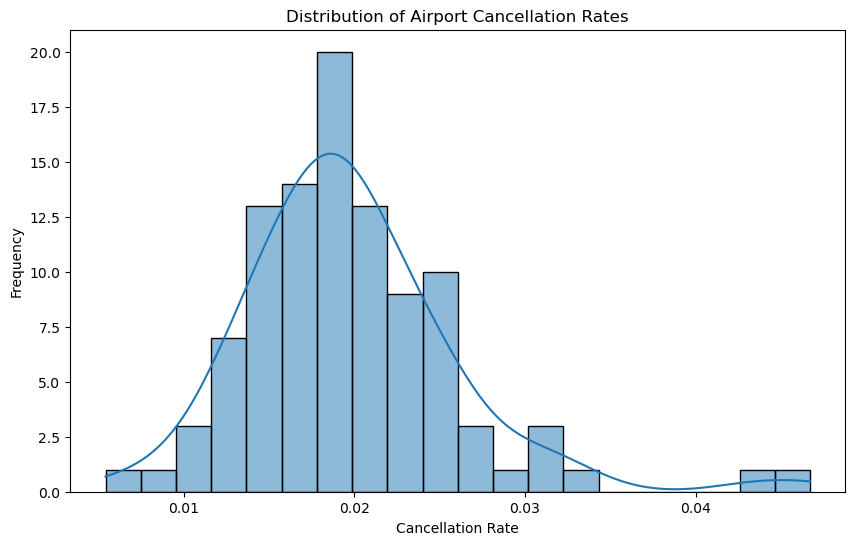

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(airport_cancelled_rate, kde=True, bins=20)
plt.title("Distribution of Airport Cancellation Rates")
plt.xlabel("Cancellation Rate")
plt.ylabel("Frequency")
plt.show()


### Airline cancellation rates

In [5]:
#we only have 10 airlines, calculate cancelled rate for each airline
airline_counts = flights_data['Marketing_Airline_Network'].value_counts()
print(airline_counts)
flights_data['Cancelled'] = pd.to_numeric(flights_data['Cancelled'], errors='coerce')

airline_cancelled_rate = flights_data.groupby('Marketing_Airline_Network')['Cancelled'].mean()

print(airline_cancelled_rate)

AA    1706880
WN    1582613
DL    1453813
UA    1268992
AS     378013
B6     307713
NK     247359
F9     163517
HA      84082
G4      52564
Name: Marketing_Airline_Network, dtype: int64
Marketing_Airline_Network
AA    0.016127
AS    0.026211
B6    0.017848
DL    0.010795
F9    0.017111
G4    0.021479
HA    0.010668
NK    0.016446
UA    0.021317
WN    0.027046
Name: Cancelled, dtype: float64


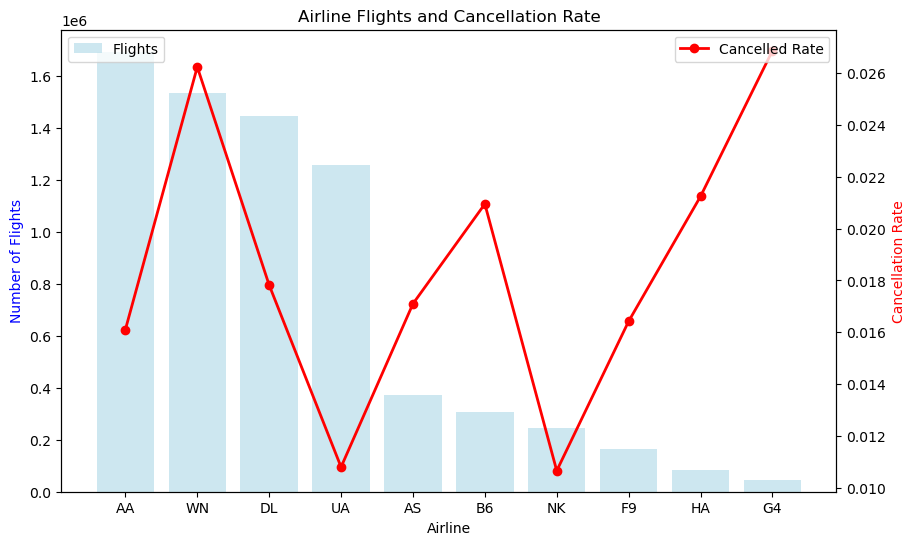

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
data = {
    'Airline': ['AA', 'WN', 'DL', 'UA', 'AS', 'B6', 'NK', 'F9', 'HA', 'G4'],
    'Flights': [1694567, 1536833, 1445449, 1260144, 372107, 306162, 245658, 163207, 84082, 46737],
    'Cancelled_Rate': [0.016106, 0.026226, 0.017821, 0.010810, 0.017101, 0.020947, 0.010668, 0.016425, 0.021238, 0.026851]
}

data1 = pd.DataFrame(data)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.bar(data['Airline'], data1['Flights'], color='lightblue', alpha=0.6, label='Flights')
ax2.plot(data['Airline'], data1['Cancelled_Rate'], color='red', marker='o', label='Cancelled Rate', linestyle='-', linewidth=2)

ax1.set_xlabel('Airline')
ax1.set_ylabel('Number of Flights', color='blue')
ax2.set_ylabel('Cancellation Rate', color='red')
plt.title('Airline Flights and Cancellation Rate')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


In [7]:
#ANOVA: significant cancelled rate different between airlines
from scipy.stats import f_oneway
groups = [flights_data['Cancelled'][flights_data['Marketing_Airline_Network'] == airline] for airline in flights_data['Marketing_Airline_Network'].unique()]
# （ANOVA）
f_stat, p_value = f_oneway(*groups)
print(f"P-value from ANOVA: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in cancellation rates among airlines.")
else:
    print("There is no significant difference in cancellation rates among airlines.")


P-value from ANOVA: 0.0
There is a significant difference in cancellation rates among airlines.


### Set 3 cancel rate level , we tried to use it in the model

In [8]:
import pandas as pd
cancel_rate = {
    'AA': 0.016106,
    'AS': 0.026226,
    'B6': 0.017821,
    'DL': 0.010810,
    'F9': 0.017101,
    'G4': 0.020947,
    'HA': 0.010668,
    'NK': 0.016425,
    'UA': 0.021238,
    'WN': 0.026851
}
cancel_rate_df = pd.DataFrame(list(cancel_rate.items()), columns=['Airline', 'CancelRate'])
def assign_cancel_level(rate):
    if rate <= 0.015:
        return 0.1 #
    elif rate <= 0.02:
        return 0.2 
    else:
        return 0.3 
cancel_rate_df['CancelLevel'] = cancel_rate_df['CancelRate'].apply(assign_cancel_level)
print(cancel_rate_df)


  Airline  CancelRate  CancelLevel
0      AA    0.016106          0.2
1      AS    0.026226          0.3
2      B6    0.017821          0.2
3      DL    0.010810          0.1
4      F9    0.017101          0.2
5      G4    0.020947          0.3
6      HA    0.010668          0.1
7      NK    0.016425          0.2
8      UA    0.021238          0.3
9      WN    0.026851          0.3


In [9]:
flights_data = flights_data.merge(cancel_rate_df[['Airline', 'CancelLevel']], 
                                  left_on='Marketing_Airline_Network', 
                                  right_on='Airline', 
                                  how='left')
flights_data = flights_data.drop('Airline', axis=1)
print(flights_data.head())


   DayOfWeek  FlightDate Marketing_Airline_Network Origin Dest  CRSDepTime  \
0          4  2018-11-15                        DL    BDL  RDU         600   
1          4  2018-11-15                        AA    BDL  MIA         618   
2          4  2018-11-15                        AA    BDL  CLT         609   
3          4  2018-11-15                        DL    BDL  ATL         600   
4          4  2018-11-15                        UA    BDL  ORD         630   

   DepTime  DepDelay  CRSArrTime  ArrTime  ...  HourlyWindSpeed_ORIGIN  \
0    600.0       0.0         750    800.0  ...                     2.6   
1    615.0      -3.0         939    929.0  ...                     2.6   
2    602.0      -7.0         826    824.0  ...                     2.6   
3    559.0      -1.0         841    832.0  ...                     2.6   
4    626.0      -4.0         808    814.0  ...                     2.6   

   REPORT_TYPE_ORIGIN AIRPORT_CODE_ORIGIN  TIME_ORIGIN  HOUR_ORIGIN  \
0              

### Convert datatype & Imputation

In [10]:
#construct 'Hour' and 'Month'
flights_data['FlightDate'] = pd.to_datetime(flights_data['FlightDate'])  
flights_data['Month'] = flights_data['FlightDate'].dt.month  
flights_data['Hour'] = flights_data['CRSDepTime'].astype(str).str.zfill(4).str[:2].astype(int) 

In [11]:
# Fill NaN values in HourlyWindSpeed_ORIGIN column with 0
flights_data['HourlyWindSpeed_DEST'] = pd.to_numeric(flights_data['HourlyWindSpeed_DEST'], errors='coerce')
flights_data['HourlyWindSpeed_DEST'].fillna(0, inplace=True)
flights_data['HourlyWindSpeed_ORIGIN'] = pd.to_numeric(flights_data['HourlyWindSpeed_DEST'], errors='coerce')
flights_data['HourlyWindSpeed_ORIGIN'].fillna(0, inplace=True)

In [12]:
#Fill NaN or 'T' in precipitation with 0
flights_data['HourlyPrecipitation_DEST'] = pd.to_numeric(flights_data['HourlyPrecipitation_DEST'], errors='coerce')
flights_data['HourlyPrecipitation_DEST'].fillna(0, inplace=True)
flights_data['HourlyPrecipitation_ORIGIN'] = pd.to_numeric(flights_data['HourlyPrecipitation_ORIGIN'], errors='coerce')
flights_data['HourlyPrecipitation_ORIGIN'].fillna(0, inplace=True)

In [13]:
#Convert Visibility to float type, delete all NaN datapoints(634/46081 total 134863/7154946)
flights_data['HourlyVisibility_ORIGIN'] = pd.to_numeric(flights_data['HourlyVisibility_ORIGIN'], errors='coerce')
flights_data['Cancelled'] = pd.to_numeric(flights_data['Cancelled'], errors='coerce')
print(flights_data['HourlyVisibility_ORIGIN'].isna().sum(), "NaN values found after conversion.")
print(flights_data[['HourlyVisibility_ORIGIN','Cancelled']][flights_data['HourlyVisibility_ORIGIN'].isna()])
sub=flights_data['Cancelled'][flights_data['HourlyVisibility_ORIGIN'].isna()]
flights_data = flights_data.dropna(subset=['HourlyVisibility_ORIGIN'])

46419 NaN values found after conversion.
         HourlyVisibility_ORIGIN  Cancelled
6051                         NaN          0
6052                         NaN          0
6053                         NaN          0
6054                         NaN          0
6055                         NaN          0
...                          ...        ...
7240715                      NaN          0
7240890                      NaN          0
7242596                      NaN          0
7245293                      NaN          0
7245367                      NaN          0

[46419 rows x 2 columns]


In [14]:
#Convert Visibility to float type, delete all NaN datapoints(634/46081 total 134863/7154946)
flights_data['HourlyVisibility_DEST'] = pd.to_numeric(flights_data['HourlyVisibility_DEST'], errors='coerce')

print(flights_data['HourlyVisibility_DEST'].isna().sum(), "NaN values found after conversion.")
print(flights_data[['HourlyVisibility_DEST','Cancelled']][flights_data['HourlyVisibility_DEST'].isna()])
sub=flights_data['Cancelled'][flights_data['HourlyVisibility_DEST'].isna()]
flights_data = flights_data.dropna(subset=['HourlyVisibility_DEST'])

41495 NaN values found after conversion.
         HourlyVisibility_DEST  Cancelled
3016                       NaN          0
4190                       NaN          0
4291                       NaN          0
4302                       NaN          0
4303                       NaN          0
...                        ...        ...
7242866                    NaN          0
7242946                    NaN          0
7243538                    NaN          0
7243759                    NaN          0
7244056                    NaN          0

[41495 rows x 2 columns]


In [15]:
flights_data['DailySnowDepth_DEST'] = pd.to_numeric(flights_data['DailySnowDepth_DEST'], errors='coerce').fillna(0)
flights_data['DailySnowfall_DEST'] = pd.to_numeric(flights_data['DailySnowfall_DEST'], errors='coerce').fillna(0)
print("DailySnowDepth_DEST distribution:")
print(flights_data['DailySnowDepth_DEST'].describe())
print("\nDailySnowfall_DEST distribution:")
print(flights_data['DailySnowfall_DEST'].describe())

print("\nDailySnowDepth_DEST value counts:")
print(flights_data['DailySnowDepth_DEST'].value_counts().head(10)) 

print("\nDailySnowfall_DEST value counts:")
print(flights_data['DailySnowfall_DEST'].value_counts().head(10))  


DailySnowDepth_DEST distribution:
count    7.157632e+06
mean     6.144551e+00
std      3.150924e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.400000e+02
Name: DailySnowDepth_DEST, dtype: float64

DailySnowfall_DEST distribution:
count    7.157632e+06
mean     1.787040e+00
std      1.333468e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.990000e+02
Name: DailySnowfall_DEST, dtype: float64

DailySnowDepth_DEST value counts:
0.0      6687581
30.0      134321
50.0       92918
80.0       58747
100.0      54801
130.0      40263
150.0      22830
180.0      19193
200.0      12299
230.0       6687
Name: DailySnowDepth_DEST, dtype: int64

DailySnowfall_DEST value counts:
0.0     6775342
3.0       60944
5.0       43077
8.0       31828
10.0      23872
13.0      20209
25.0      15982
15.0      15186
18.0      14631
23.0      12235
Name: DailySnowfall_DEST, dtype: int64


In [16]:
flights_data['DailySnowDepth_ORIGIN'] = pd.to_numeric(flights_data['DailySnowDepth_ORIGIN'], errors='coerce').fillna(0)
flights_data['DailySnowfall_ORIGIN'] = pd.to_numeric(flights_data['DailySnowfall_ORIGIN'], errors='coerce').fillna(0)
print("DailySnowDepth_DEST distribution:")
print(flights_data['DailySnowDepth_ORIGIN'].describe())
print("\nDailySnowfall_DEST distribution:")
print(flights_data['DailySnowfall_ORIGIN'].describe())
print("\nDailySnowDepth_DEST value counts:")
print(flights_data['DailySnowDepth_ORIGIN'].value_counts().head(10)) 
print("\nDailySnowfall_DEST value counts:")
print(flights_data['DailySnowfall_ORIGIN'].value_counts().head(10)) 

DailySnowDepth_DEST distribution:
count    7.157632e+06
mean     6.136233e+00
std      3.147167e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.400000e+02
Name: DailySnowDepth_ORIGIN, dtype: float64

DailySnowfall_DEST distribution:
count    7.157632e+06
mean     1.785287e+00
std      1.333419e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.990000e+02
Name: DailySnowfall_ORIGIN, dtype: float64

DailySnowDepth_DEST value counts:
0.0      6687818
30.0      134383
50.0       92856
80.0       58718
100.0      54838
130.0      40218
150.0      22770
180.0      19169
200.0      12275
230.0       6676
Name: DailySnowDepth_ORIGIN, dtype: int64

DailySnowfall_DEST value counts:
0.0     6775671
3.0       60840
5.0       43051
8.0       31830
10.0      23874
13.0      20236
25.0      15969
15.0      15177
18.0      14611
23.0      12225
Name: DailySnowfall_ORIGIN, dtype: int64


In [17]:
# try one-hot encoding for airlines
#airline_dummies = pd.get_dummies(flights_data['Marketing_Airline_Network'], prefix='Airline')
#flights_data = pd.concat([flights_data, airline_dummies], axis=1)
#flights_data = flights_data.drop('Marketing_Airline_Network', axis=1)


#  2.Model

In [18]:
#pip install imbalanced-learn #run if not already installed


In [19]:
#conda install -c conda-forge imbalanced-learn #run if not already installed


## 2.1 Cancellation model

### Logistic Regression

We've tried different predictors and thresholds. To make it concise, we only show our final model here.
The final model is using 'Month','Visibility at origin','WindSpeed at destination','SnowDepth at origin','SnowDepth at destination' as predictors. Visibility and WindSpeed are set to 3 catagories and SnowDepth is set to 2 catagories. 

In [20]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_auc_score, precision_score

#target_airlines = ['AA', 'WN', 'DL', 'UA']
flights_data_filtered = flights_data#[flights_data['Marketing_Airline_Network'].isin(target_airlines)]

cancelled = flights_data_filtered[flights_data_filtered['Cancelled'] == 1]
cancelled = cancelled[cancelled['CancellationCode']=='B']
not_cancelled = flights_data_filtered[flights_data_filtered['Cancelled'] == 0].sample(len(cancelled), random_state=42)
flights_data_balanced = pd.concat([cancelled, not_cancelled])

X_base = flights_data_balanced[['Month']]
y = flights_data_balanced['Cancelled']
best_threshold = None
best_recall = -10

def categorize_visibility(vis):
    if vis > 16:
        return 0
    elif vis > 6:
        return 1
    else:
        return 2

def categorize_wind_speed(wind):
    if wind < 4:#this threshold is decided after testing different thresholds
        return 0
    elif wind < 10:
        return 1
    else:
        return 2
def categorize_snow_fall(snow):
    if snow <=0:
        return 0 
    else:
        return 1

flights_data_balanced['Vis_ORIGIN_category'] = flights_data_balanced['HourlyVisibility_ORIGIN'].apply(categorize_visibility)
flights_data_balanced['Wind_DEST_category'] = flights_data_balanced['HourlyWindSpeed_DEST'].apply(categorize_wind_speed)
flights_data_balanced['Snow_DEST_category'] = flights_data_balanced['DailySnowfall_DEST'].apply(categorize_snow_fall)
flights_data_balanced['Snow_ORIGIN_category'] = flights_data_balanced['DailySnowfall_ORIGIN'].apply(categorize_snow_fall)
X = X_base.copy()
X['Vis_ORIGIN_category'] = flights_data_balanced['Vis_ORIGIN_category']
X['Wind_DEST_category'] = flights_data_balanced['Wind_DEST_category']
X['Snow_ORIGIN_category'] = flights_data_balanced['Snow_ORIGIN_category']
X['Snow_DEST_category'] = flights_data_balanced['Snow_DEST_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
custom_threshold = 0.46# we also adjust the threshold of Logistic regression to get the best recall &accuracy
y_pred_custom = (y_prob >= custom_threshold).astype(int)

recall = recall_score(y_test, y_pred_custom)
accuracy = accuracy_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"recall: {recall}, accuracy: {accuracy}, precision: {precision}, f1_score: {f1}, roc_auc: {roc_auc}")

recall: 0.7607036417823654, accuracy: 0.7533880301809391, precision: 0.7525528548827844, f1_score: 0.7566062972201135, roc_auc: 0.8265905101287003


In [21]:
#review order of X cols to check model_predict.py functions
X_train.head()

Month  Vis_ORIGIN_category  Wind_DEST_category  Snow_ORIGIN_category  \
6418042     12                    0                   0                     0   
3363595      1                    0                   0                     0   
5380939      1                    0                   0                     0   
4434695      1                    0                   0                     0   
5453720      1                    0                   1                     0   

         Snow_DEST_category  
6418042                   0  
3363595                   0  
5380939                   0  
4434695                   0  
5453720                   0

##### Save Cancellation Model to pickle file

In [22]:
#save model to .pkl so it can be used to predict values in Shiny app
import pickle
with open('cancel_model.pkl','wb') as f:
    pickle.dump(model,f)

### 
### Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model.fit(X_train, y_train)

y_tree_pred = tree_model.predict(X_test)
tree_recall = recall_score(y_test, y_tree_pred, average='macro')
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_precision = precision_score(y_test, y_tree_pred, average='macro')
tree_f1 = f1_score(y_test, y_tree_pred, average='macro')

print(f"Decision Tree - Recall: {tree_recall}, Accuracy: {tree_accuracy}, Precision: {tree_precision}, F1 Score: {tree_f1}")


Decision Tree - Recall: 0.7580093444424668, Accuracy: 0.7572705296315289, Precision: 0.7672687459565374, F1 Score: 0.7553210498195349


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

cancelled_flights = flights_data[flights_data['Cancelled'] == 1]


plt.figure(figsize=(10, 6))
sns.histplot(cancelled_flights['HourlyVisibility_ORIGIN'], bins=30, kde=True)
plt.title('Visibility Distribution for Cancelled Flights')
plt.xlabel('Hourly Visibility at Origin (miles)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='Cancelled', y='HourlyVisibility_ORIGIN', data=flights_data)
plt.title('Visibility Comparison for Cancelled and Non-cancelled Flights')
plt.xlabel('Cancelled (1 = Yes, 0 = No)')
plt.ylabel('Hourly Visibility at Origin (miles)')
plt.show()

## 2.2 Delay model

prepare the delay dataset

In [25]:
#exclude canceled flights
flights_delay= flights_data.dropna(subset=['ArrDelay'])

In [26]:
flights_delay['ArrDelay'] = pd.to_numeric(flights_delay['ArrDelay'], errors='coerce')

C:\Users\armer\AppData\Local\Temp\ipykernel_21596\4115167088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_delay['ArrDelay'] = pd.to_numeric(flights_delay['ArrDelay'], errors='coerce')


In [27]:

#flights_delay['CarrierDelay'] = pd.to_numeric(flights_delay['CarrierDelay'], errors='coerce')
#flights_delay['WeatherDelay'] = pd.to_numeric(flights_delay['CarrierDelay'], errors='coerce')
#flights_delay['NASDelay'] = pd.to_numeric(flights_delay['CarrierDelay'], errors='coerce')
f#lights_delay['SecurityDelay'] = pd.to_numeric(flights_delay['CarrierDelay'], errors='coerce')

<_io.BufferedWriter name='cancel_model.pkl'>

In [28]:
#flights_delay['WeatherDelay'].fillna(0, inplace=True)

In [29]:
flights_delay['AirTime'] = pd.to_numeric(flights_delay['AirTime'], errors='coerce')
flights_delay['Distance'] = pd.to_numeric(flights_delay['Distance'], errors='coerce')

C:\Users\armer\AppData\Local\Temp\ipykernel_21596\273410568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_delay['AirTime'] = pd.to_numeric(flights_delay['AirTime'], errors='coerce')
C:\Users\armer\AppData\Local\Temp\ipykernel_21596\273410568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_delay['Distance'] = pd.to_numeric(flights_delay['Distance'], errors='coerce')


In [30]:
def convert_delay_to_category(delay):
    if delay <= 0:
        return 0
    elif delay < 60:
        return 1
    else:  # delay >= 60
        return 2
flights_delay['delay_category'] = flights_delay['ArrDelay'].apply(convert_delay_to_category)

C:\Users\armer\AppData\Local\Temp\ipykernel_21596\1811638034.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_delay['delay_category'] = flights_delay['ArrDelay'].apply(convert_delay_to_category)


### prob of flight delays

Only 35% flights arrive later than expected

In [31]:
len(flights_delay['ArrDelay'][flights_delay['ArrDelay']>0])/len(flights_delay['ArrDelay'])

0.34913893588323097

Only 18% arrive > 15 min late

In [32]:
len(flights_delay['ArrDelay'][flights_delay['ArrDelay']>15])/len(flights_delay['ArrDelay'])

0.18189535402314527

Only 6% arrive >60 min late

In [33]:
len(flights_delay['ArrDelay'][flights_delay['ArrDelay']>60])/len(flights_delay['ArrDelay'])

0.057965923815236096

In [34]:
len(flights_delay['ArrDelay'][flights_delay['ArrDelay']>=300])/len(flights_delay['ArrDelay'])

0.0033559143960766535

but there are some delayed > 15h +

In [35]:
print(flights_delay[flights_delay['ArrDelay']>=1000])

         DayOfWeek FlightDate Marketing_Airline_Network Origin Dest  \
2260             1 2018-11-26                        DL    ORD  MSP   
20235            4 2018-11-15                        UA    BOS  CLE   
22527            7 2018-11-25                        DL    MSP  ORD   
32163            1 2018-11-26                        UA    EWR  ORD   
36588            4 2018-11-15                        DL    PIT  ATL   
...            ...        ...                       ...    ...  ...   
7216101          1 2024-01-08                        F9    BDL  MCO   
7231041          4 2023-11-02                        B6    ONT  JFK   
7232527          3 2024-01-17                        DL    BOI  SEA   
7234163          6 2024-01-13                        DL    OMA  ATL   
7238172          7 2024-01-21                        DL    JFK  BUF   

         CRSDepTime  DepTime  DepDelay  CRSArrTime  ArrTime  ...  TIME_ORIGIN  \
2260            610   2340.0    1050.0         748    104.0  ...  

In [36]:
sum(flights_delay['ArrDelay'])/len(flights_delay['ArrDelay'])

4.030220778134995

On average, flights delayed for 4 min

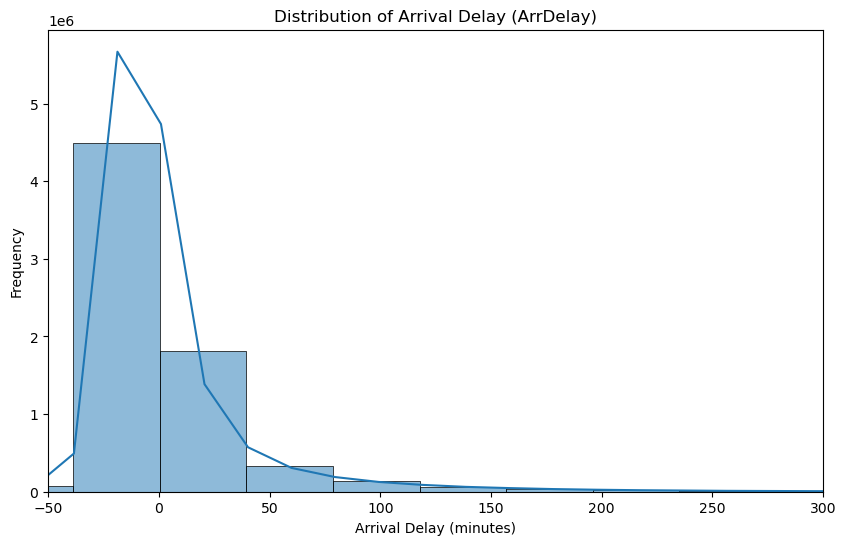

In [37]:
arr_delay_data = flights_data['ArrDelay'].dropna()  

plt.figure(figsize=(10, 6))
sns.histplot(arr_delay_data, bins=100, kde=True)  
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Delay (ArrDelay)')
plt.xlim(-50, 300)  
plt.show()

## Model selection

###    Logistic Regression

In [38]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
#target_airlines = ['AA', 'WN', 'DL', 'UA']
flights_data_filtered = flights_delay#[flights_delay['Marketing_Airline_Network'].isin(target_airlines)]

delay2 = flights_data_filtered[flights_data_filtered['delay_category'] == 2]
delay1 = flights_data_filtered[flights_data_filtered['delay_category'] == 1].sample(len(delay2), random_state=42)
delay0 = flights_data_filtered[flights_data_filtered['delay_category'] == 0].sample(len(delay2), random_state=42)
flights_data_balanced = pd.concat([delay0, delay1, delay2])

X_base = flights_data_balanced[['Month','Hour']]#,'DaysUntilHol']]
y = flights_data_balanced['delay_category']  

def categorize_visibility(vis):
    if vis > 16:
        return 0
    elif vis > 6:
        return 1
    else:
        return 2

def categorize_wind_speed(wind):
    if wind < 4:
        return 0
    elif wind < 10:
        return 1
    else:
        return 2
def categorize_snow_fall(snow):
    if snow <= 3:
        return 0 
    else:
        return 1

flights_data_balanced['Vis_ORIGIN_category'] = flights_data_balanced['HourlyVisibility_ORIGIN'].apply(categorize_visibility)
flights_data_balanced['Wind_DEST_category'] = flights_data_balanced['HourlyWindSpeed_DEST'].apply(categorize_wind_speed)
flights_data_balanced['Snow_DEST_category'] = flights_data_balanced['DailySnowfall_DEST'].apply(categorize_snow_fall)
#flights_data_balanced['Pre_ORIGIN_category'] = flights_data_balanced['HourlyPrecipitation_ORIGIN'].apply(categorize_snow_fall)
flights_data_balanced['Snow_ORIGIN_category'] = flights_data_balanced['DailySnowfall_ORIGIN'].apply(categorize_snow_fall)
X = X_base.copy()
X['Vis_ORIGIN_category'] = flights_data_balanced['Vis_ORIGIN_category']
#X['Pre_ORIGIN_category'] = flights_data_balanced['Pre_ORIGIN_category']
X['Wind_DEST_category'] = flights_data_balanced['Wind_DEST_category']
X['Snow_ORIGIN_category'] = flights_data_balanced['Snow_ORIGIN_category']
X['Snow_DEST_category'] = flights_data_balanced['Snow_DEST_category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

recall = recall_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Recall: {recall}, Accuracy: {accuracy}, Precision: {precision}, F1 Score: {f1}")

C:\Users\armer\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Recall: 0.41233109177243626, Accuracy: 0.41218557223740176, Precision: 0.40260292944051107, F1 Score: 0.3956403578902615


In [39]:
#review order of X_train cols to check model_predict.py
X_train.head()

Month  Hour  Vis_ORIGIN_category  Wind_DEST_category  \
5014967     11    11                    1                   0   
4802750      1     6                    0                   1   
4842929     11    10                    0                   1   
3265243     11     7                    0                   0   
5054821     12     8                    1                   2   

         Snow_ORIGIN_category  Snow_DEST_category  
5014967                     0                   0  
4802750                     0                   0  
4842929                     0                   0  
3265243                     0                   0  
5054821                     0                   0

##### save delay model to pickle file

In [40]:
#save final selected delay model to .pkl to be used by the Shiny app for prediction

In [41]:
#save model to .pkl so it can be used to predict values in Shiny app
with open('delay_model.pkl','wb') as f:
    pickle.dump(model,f)

### Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model.fit(X_train, y_train)
y_tree_pred = tree_model.predict(X_test)
tree_recall = recall_score(y_test, y_tree_pred, average='macro')
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_precision = precision_score(y_test, y_tree_pred, average='macro')
tree_f1 = f1_score(y_test, y_tree_pred, average='macro')

print(f"Decision Tree - Recall: {tree_recall}, Accuracy: {tree_accuracy}, Precision: {tree_precision}, F1 Score: {tree_f1}")


Decision Tree - Recall: 0.4178394449219276, Accuracy: 0.4177025194461323, Precision: 0.4088988632421677, F1 Score: 0.40316757314864365


### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

y_rf_pred = rf_model.predict(X_test)

rf_recall = recall_score(y_test, y_rf_pred, average='macro')
rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_precision = precision_score(y_test, y_rf_pred, average='macro')
rf_f1 = f1_score(y_test, y_rf_pred, average='macro')

print(f"Random Forest - Recall: {rf_recall}, Accuracy: {rf_accuracy}, Precision: {rf_precision}, F1 Score: {rf_f1}")


Random Forest - Recall: 0.4179148871843597, Accuracy: 0.4177830000764566, Precision: 0.40917003099866284, F1 Score: 0.40417291397820176


### Gradient Boosting Machine

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)
y_gbc_pred = gbc_model.predict(X_test)

gbc_recall = recall_score(y_test, y_gbc_pred, average='macro')
gbc_accuracy = accuracy_score(y_test, y_gbc_pred)
gbc_precision = precision_score(y_test, y_gbc_pred, average='macro')
gbc_f1 = f1_score(y_test, y_gbc_pred, average='macro')

print(f"Gradient Boosting - Recall: {gbc_recall}, Accuracy: {gbc_accuracy}, Precision: {gbc_precision}, F1 Score: {gbc_f1}")


Gradient Boosting - Recall: 0.4185752889823399, Accuracy: 0.4184389172135996, Precision: 0.40883608778554387, F1 Score: 0.40304747852779244


svm takes really long time to compute

In [45]:
#from sklearn.svm import SVC
#svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
#svm_model.fit(X_train, y_train)
#y_svm_pred = svm_model.predict(X_test)
#svm_recall = recall_score(y_test, y_svm_pred, average='macro')
#svm_accuracy = accuracy_score(y_test, y_svm_pred)
#svm_precision = precision_score(y_test, y_svm_pred, average='macro')
#svm_f1 = f1_score(y_test, y_svm_pred, average='macro')
#print(f"SVM - Recall: {svm_recall}, Accuracy: {svm_accuracy}, Precision: {svm_precision}, F1 Score: {svm_f1}")
